### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import prophet
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn import metrics
from utils import build_recency_count, build_frequency_count, build_monetary_value, build_age_count

%matplotlib inline

In [3]:
df = pd.read_csv('~/assignment.csv')

In [4]:
df.shape

(198101, 3)

In [5]:
df['timestamp_dt'] = pd.to_datetime(df['timestamp'])
df['purchase_date'] = df['timestamp_dt'].dt.date

In [6]:
# check how many users we have 
print(f"The data set has {df.user_id.nunique()} unique users.")

The data set has 23583 unique users.


In [7]:
# check the time range of data given to us
df.timestamp_dt.min(), df.timestamp_dt.max()

(Timestamp('2022-08-15 18:33:11.511000'),
 Timestamp('2022-12-14 09:45:03.991000'))

<AxesSubplot: xlabel='timestamp_dt'>

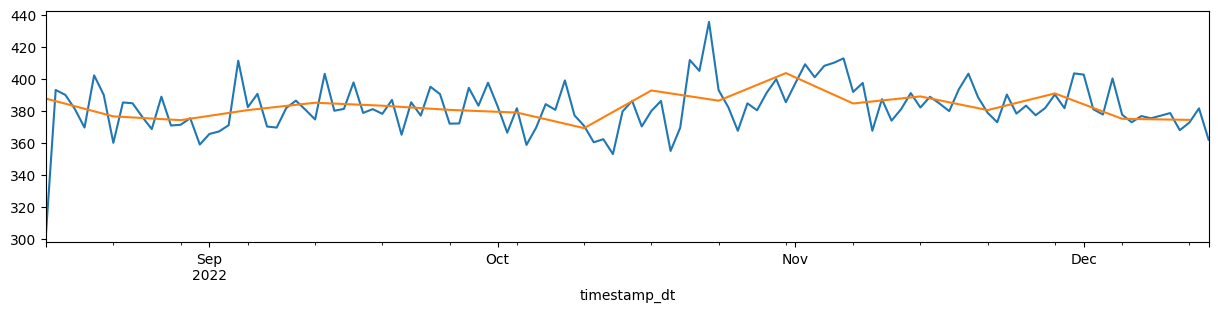

In [8]:
# check daily and weekly trend of average purchase amount
df.set_index('timestamp_dt').resample('D').purchase_value.mean().plot(figsize=(15, 3))
df.set_index('timestamp_dt').resample('W').purchase_value.mean().plot(figsize=(15, 3))

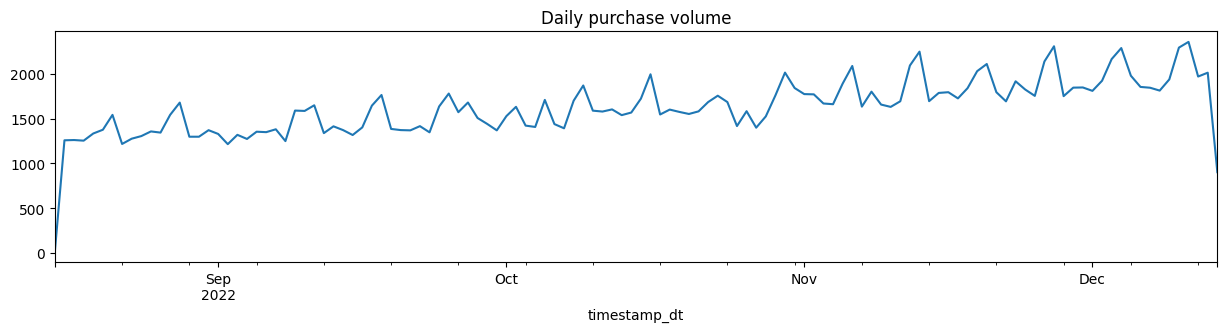

In [9]:
df.set_index('timestamp_dt').resample('D')['timestamp'].count().plot(figsize=(15, 3))
_=plt.title('Daily purchase volume')

**Observations**

* The daily purchase trend looks normal and is repeating consistenly. Although, we do observe an uncanny drop in purchases in the mid of October. On some day, the daily average drops as compared to weekly average. 

<AxesSubplot: >

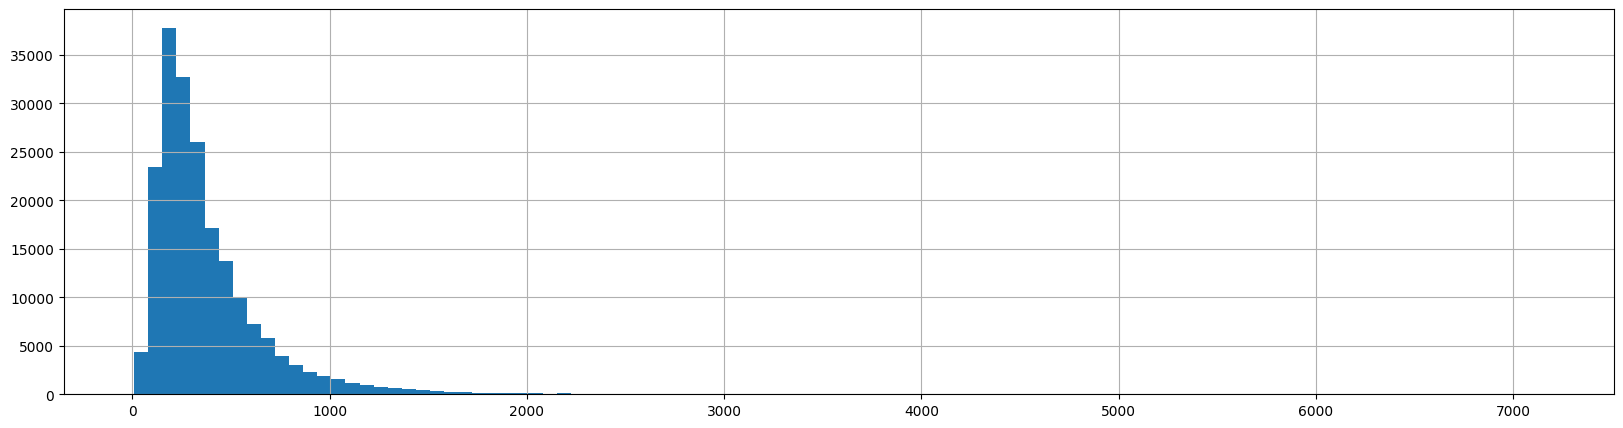

In [10]:
# purchase value distribution is right skewed
df['purchase_value'].hist(bins=100, figsize=(20, 5))

Lets cut off the purchase value to 99th percentile.

In [11]:
df['purchase_value'] = df['purchase_value'].clip(0, 2000) # 99th percentile

### Training Data

* We consider last two months (Nov, Dec) as holdout periods to prediction churn. 
* A user is considered as churned is they didn't make any purchase in the last two months.

In [13]:
tmp=  df.groupby(['user_id', pd.Grouper(key='timestamp_dt', freq='M')])['purchase_value'].sum().unstack().reset_index()
tmp.columns = [str(x).split(' ')[0] for x in tmp.columns]

tmp['na_count'] = tmp.isna().sum(axis=1)
tmp['na_count_last2'] = tmp[['2022-11-30', '2022-12-31']].isna().sum(axis=1)

In [14]:
tmp['is_sum'] = tmp.iloc[:,1:6].sum(axis=1)

In [15]:
# set last two months null transaction as churned customer
tmp['is_churn'] = tmp['na_count_last2'].eq(2).astype(int)
tmp['is_churn'].value_counts(normalize=True)

0    0.68736
1    0.31264
Name: is_churn, dtype: float64

The data set is imbalanced. We'll use class weights strategy to assign higher weight to positive class labels. 

In [16]:
# create training and holdout split based on time
cut_off = df['purchase_date'].max() - pd.Timedelta("44 days")
print(f'{cut_off=}')
train = df[df['purchase_date'] < cut_off].copy()
test = df[df['purchase_date'] >= cut_off].copy()
train.shape, test.shape

cut_off=datetime.date(2022, 10, 31)


((113594, 5), (84507, 5))

### Feature Engineering

* We mainly create recency, frequency, age and amount features. These are:
  * *Recency* : How recently a user has interacted with the platform
  * *Frequency* : How frequently the user interacts with the platform
  * *Age* : How old is the user on the platform
  * *Amount* : Total money spent by the user on the platform
  * *Avg Amount* : How much (on an average) the user spends on the platform

In [18]:
train_recency = build_recency_count(train)
train_frequency = build_frequency_count(train)
train_value = build_monetary_value(train)
train_age = build_age_count(train)

(19003, 2)

In [22]:
rfm_df = (train_recency
          .merge(train_frequency, on='user_id')
          .merge(train_value, on='user_id')
          .merge(train_age, on='user_id')
         )
rfm_df.shape

(19003, 5)

In [23]:
rfm_df['avg_value'] = rfm_df['value'] / rfm_df['frequency']

In [24]:
rfm_df = rfm_df.merge(tmp[['user_id', 'is_churn']], on='user_id')

In [25]:
# create target variable to predict clv
rfm_df['clv'] = rfm_df['user_id'].map(test.groupby('user_id')['purchase_value'].sum())
rfm_df['clv'] = rfm_df['clv'].fillna(0)

### Split the data
* Here we do stratified sampling to ensure the target distribution is maintained in train and validation set.

In [26]:
from sklearn.model_selection import train_test_split

cols = ['recency', 'frequency', 'value', 'age', 'avg_value']
X_train, X_test, y_train, y_test = train_test_split(rfm_df, 
                                                    rfm_df.is_churn, 
                                                    test_size=0.2, 
                                                    stratify=rfm_df['is_churn'],
                                                    random_state=42, 
                                                    shuffle=True)
X_train.shape, X_test.shape

((15202, 8), (3801, 8))

## Predict Churn

* We'll try two algorithms: Random Forest & XGBoost. 
* We'll use all default parameters. 
* Later, we'll ensemble the predictions.

### Train RF

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(X_train[cols], y_train)

In [28]:
pred_rf = rf.predict(X_test[cols])
pred_prob_rf = rf.predict_proba(X_test[cols])[:,1]

In [29]:
print(classification_report(y_test, pred_rf))
print(f'{roc_auc_score(y_test, pred_prob_rf) = }')

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      2348
           1       0.63      0.55      0.59      1453

    accuracy                           0.71      3801
   macro avg       0.69      0.68      0.68      3801
weighted avg       0.70      0.71      0.70      3801

roc_auc_score(y_test, pred_prob_rf) = 0.7756647528288415


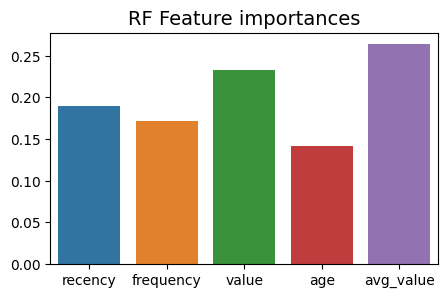

In [30]:
plt.figure(figsize=(5, 3))
g = sns.barplot(x=rf.feature_names_in_, 
                y=rf.feature_importances_)
g.set_title("RF Feature importances", fontsize=14);   

### Train XGB

In [31]:
import xgboost

In [32]:
xgb = xgboost.XGBClassifier(scale_pos_weight=sum(y_train == 0)/sum(y_train == 1))

In [33]:
xgb.fit(X_train[cols], y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [34]:
pred_xgb = xgb.predict(X_test[cols])
pred_prob_xgb = xgb.predict_proba(X_test[cols])[:,1]

In [35]:
print(classification_report(y_test, pred_xgb))
print(f'{roc_auc_score(y_test, pred_prob_xgb) = }')

              precision    recall  f1-score   support

           0       0.82      0.72      0.77      2348
           1       0.63      0.75      0.68      1453

    accuracy                           0.73      3801
   macro avg       0.73      0.74      0.73      3801
weighted avg       0.75      0.73      0.74      3801

roc_auc_score(y_test, pred_prob_xgb) = 0.8049503406568799


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

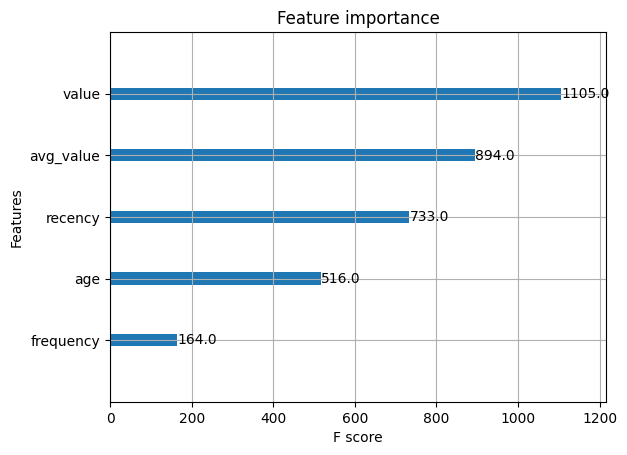

In [36]:
xgboost.plot_importance(xgb)

#### Ensemble Predictions

In [37]:
pred_ens_prob = (pred_prob_rf + pred_prob_xgb)/2
pred_ens = np.where(pred_ens_prob >= 0.5, 1, 0)

In [38]:
print(classification_report(y_test, pred_ens))
print(f'{roc_auc_score(y_test, pred_ens_prob) = }')

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      2348
           1       0.64      0.67      0.66      1453

    accuracy                           0.73      3801
   macro avg       0.71      0.72      0.72      3801
weighted avg       0.73      0.73      0.73      3801

roc_auc_score(y_test, pred_ens_prob) = 0.7988356932903902


**Observations**

* Xgboost model gives the best AUC 0.80
* Ensemble predictions aren't any better than xgboost model. 

## Predict CLV

Here we should predict CLV for top users assuming they haven't made any past purchase. This means, we are predicting for new users for whom we don't have any information. In such cases, we create an approximate model using existing users which can be later extraploted for new users:

We'll follow approach as follows:
* Sample top 1000 users based on purchased value.
* Create a data set with average daily purchase amount. 
* Use a time series model to predict the next n days. We'll take n = 30.

In [41]:
top_1000_users=tmp.sort_values('is_sum', ascending=False).head(1000)['user_id'].tolist()

In [83]:
ts_df = df.query("user_id in @top_1000_users").copy()
ts_df = ts_df.groupby(['user_id', pd.Grouper(key='timestamp_dt', freq='D')])['purchase_value'].mean().reset_index(name='purchase_avg')
ts_df = ts_df.set_index('timestamp_dt').resample('D')['purchase_avg'].mean().reset_index(name='purchase_mean')

ts_df.columns=['ds', 'y']

In [85]:
m = prophet.Prophet(daily_seasonality='auto', weekly_seasonality='auto')
m.fit(ts_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.48304


/opt/homebrew/Caskroom/miniconda/base/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       328.218   0.000836401        116.93   6.166e-06       0.001      140  LS failed, Hessian reset 
      99       328.405   0.000163823        81.582      0.6819      0.6819      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       328.439    3.9197e-05       80.7974   4.858e-07       0.001      278  LS failed, Hessian reset 
     199        328.44   3.87101e-09       77.2267      0.2236      0.2236      329   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [86]:
# lets predict for any random user for the next one month.
future = m.make_future_dataframe(periods=30)

In [87]:
forecast = m.predict(future)

/opt/homebrew/Caskroom/miniconda/base/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/homebrew/Caskroom/miniconda/base/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [92]:
top_user_clv = forecast.query("ds > '2022-12-14'")['yhat'].sum()
print(f"CLV of a top userL: {top_user_clv} ")

CLV of a top userL: 15319.969955147739 


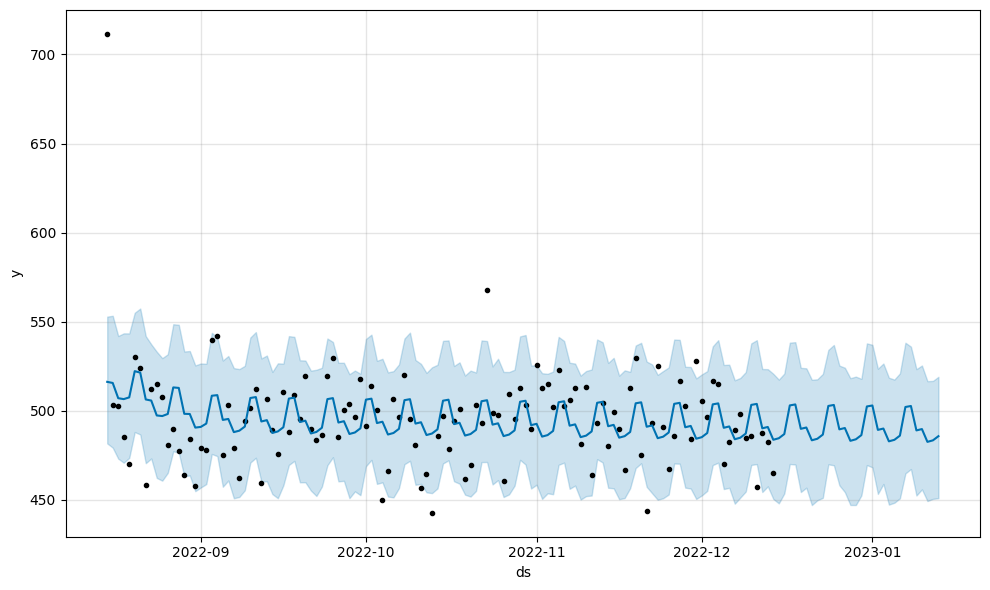

In [61]:
fig1 = m.plot(forecast)

/opt/homebrew/Caskroom/miniconda/base/envs/py38/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


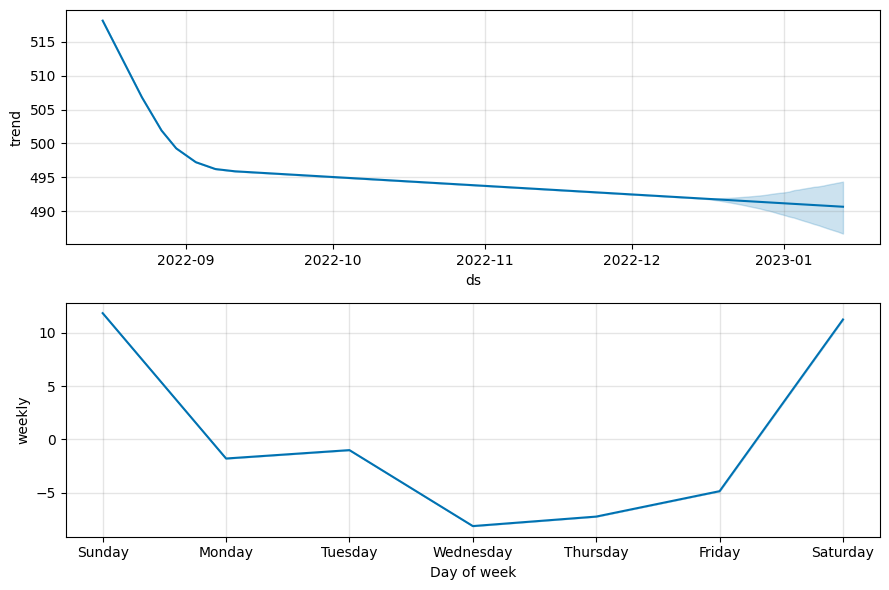

In [62]:
fig2 = m.plot_components(forecast)

**Further Ideas**

* The same approach can be extended by categorising top users into buckets and predicting separately for each bucket. Above, we have considered all users in one bucket.
* Instead of prophet, we can hand create features like lag, lead and use a non time series model like GBT, RF model to predict CLV. 